In [1301]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import math

In [1302]:
# 读取数据，pd.read_csv默认生成DataFrame对象，需将其转换成Series对象
df_ori = pd.read_csv('../../dataset/HD-year.csv',header=0)
df_ori.index = pd.to_datetime(df_ori['Date'])  # 将字符串索引转换成时间索引
#df=df_ori.asfreq(freq='3d',method='ffill')
df_ori.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2018-02-01,2018-02-01,199.339996,202.250000,198.279999,199.899994,194.037582,3553800
2018-02-02,2018-02-02,199.250000,199.300003,193.440002,193.970001,188.281494,6179000
2018-02-05,2018-02-05,190.070007,194.300003,180.380005,183.110001,177.739990,10618500
2018-02-06,2018-02-06,178.619995,191.960007,175.419998,191.039993,185.437424,11682700
2018-02-07,2018-02-07,190.729996,194.520004,189.720001,191.289993,185.680084,6016800


In [1303]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
sc_close=sc.fit_transform(df_ori['Close'].values.reshape(-1,1))

In [1304]:
def data_to_x_y(data,n_in_steps,n_out_steps):
    X_data,y_data=[],[]
    for i in range(0,data.shape[0]-n_in_steps-n_out_steps):
        X_data.append(data[i:i+n_in_steps])
        y_data.append(data[i+n_in_steps+n_out_steps-1])
    X_data=np.array(X_data)
    y_data=np.array(y_data)
    #X_data=X_data.reshape(X_train.shape[0],X_train.shape[1],1)
    #y_data=y_data.reshape(y_train.shape[0],1)
    return X_data,y_data

In [1305]:
timestep=12
outstep=60

In [1306]:
X_train,y_train=data_to_x_y(sc_close,timestep,outstep)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1])
y_train=y_train.reshape(y_train.shape[0])
print(X_train.shape)
print(y_train.shape)

(180, 12)
(180,)


In [1307]:
#SVR Model
svr_rbf = SVR(kernel='rbf', C=10,gamma=10)
rbf_fit = svr_rbf.fit(X_train, y_train)

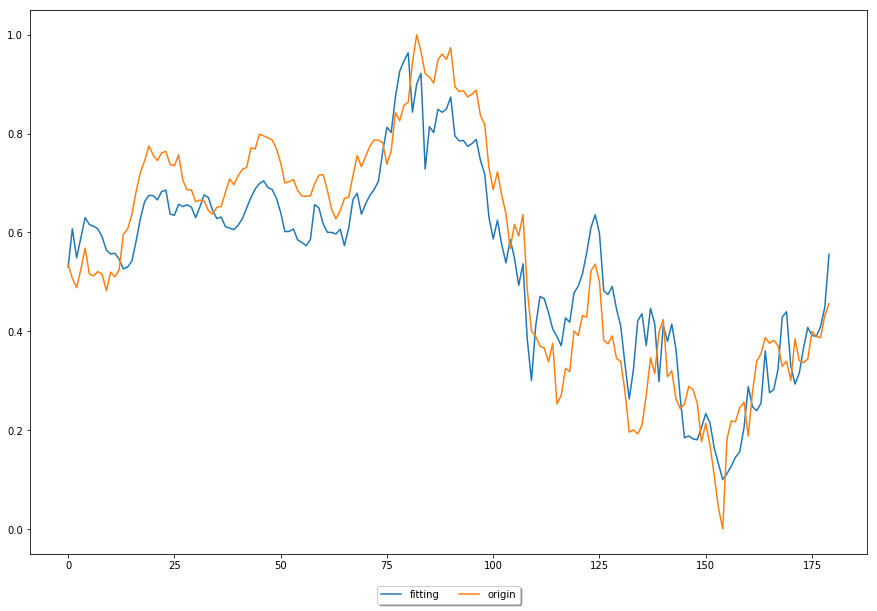

In [1308]:
#训练集拟合
ypre=rbf_fit.predict(X_train)
plt.figure(figsize=(15,10))
plt.plot(ypre,label='fitting')
plt.plot(y_train,label='origin')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.show()

In [1309]:
def generate_test(data,n_in_steps,n_out_steps):
    X_test=[]
    for i in range(data.shape[0]-n_out_steps,data.shape[0]):
            X_test.append(data[i-n_in_steps:i])
    X_test=np.array(X_test)
    return X_test

In [1310]:
X_test=generate_test(sc_close,timestep,outstep)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1])
print(X_test.shape)

(60, 12)


In [1311]:
yhat=rbf_fit.predict(X_test)
print(yhat.shape)
inv_yhat=sc.inverse_transform(yhat.reshape(-1,1))
df_all=pd.read_csv('../../dataset/HD-year-now.csv',header=0)
ytest=df_all[df_ori.shape[0]:df_ori.shape[0]+outstep]['Close']
ytest.head()

(60,)


252    186.429993
253    186.389999
254    184.720001
255    184.070007
256    184.539993
Name: Close, dtype: float64

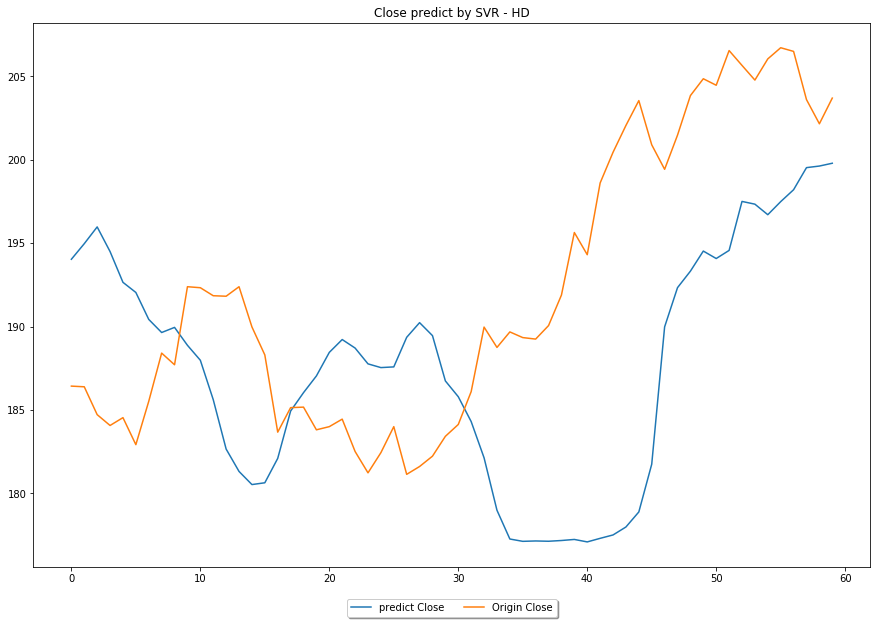

In [1312]:
plt.figure(figsize=(15,10))
plt.plot(inv_yhat,label = 'predict Close')
plt.plot(ytest.values,label = 'Origin Close')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('Close predict by SVR - HD')
plt.show()

In [1313]:
#误差统计
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

avg=np.mean(ytest.values)

rmse=math.sqrt(mean_squared_error(inv_yhat, ytest.values))
mae=mean_absolute_error(inv_yhat, ytest.values)

rmse_error_percentage=rmse/avg
mae_error_percentage=mae/avg
print('TEST RMSE: %.4f' % rmse)
print('TEST MAE: %.4f'% mae)
print("Test RMSE Error Percentage: %.2f/100.00" % (rmse_error_percentage * 100))
print("Test MAE Error Percentage: %.2f/100.00" % (mae_error_percentage * 100))

TEST RMSE: 10.4591
TEST MAE: 8.7813
Test RMSE Error Percentage: 5.44/100.00
Test MAE Error Percentage: 4.57/100.00


In [1314]:
inv_ypre=df_ori['Close'].values
iy=inv_yhat.reshape(-1)
#inv_all=np.vstack((inv_ypre,iy))
inv_all=np.append(inv_ypre,iy)
close_all=df_all['Close'].values

In [1315]:
print(inv_all.shape)
print(close_all.shape)

(312,)
(313,)


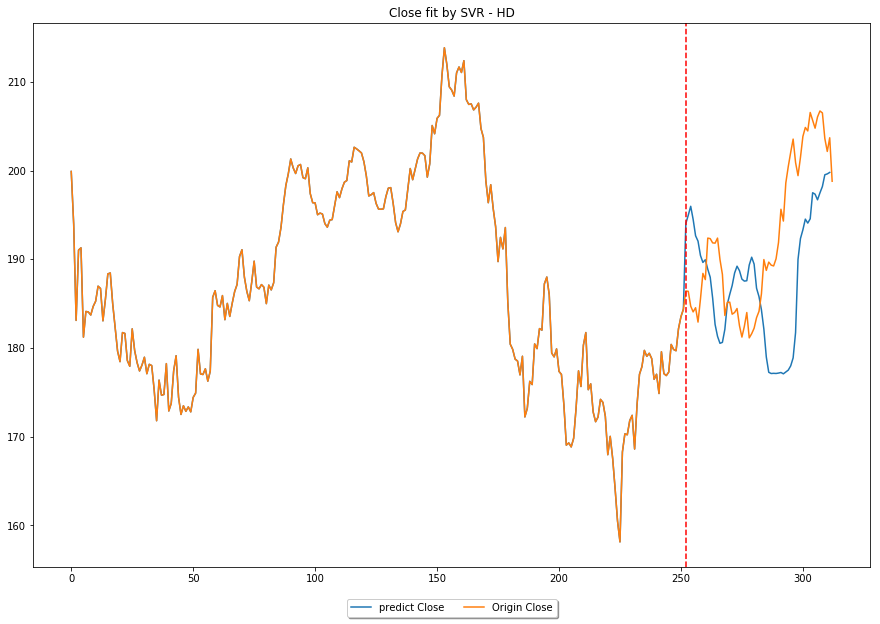

In [1316]:
plt.figure(figsize=(15,10))
plt.plot(inv_all,label = 'predict Close')
plt.plot(close_all,label = 'Origin Close')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.axvline(df_ori.shape[0],label="1",color='r',linestyle="--")
plt.title('Close fit by SVR - HD')
plt.show()